In [16]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
from jax import lax

from utils.sample_circle import *
from utils.gaussPulse import *
from utils.getSoundSpeed import *
from utils.visuals import *

import matplotlib.pyplot as plt 
jax.config.update("jax_enable_x64", True)

from IPython.display import display
import time as tt
from PIL import Image
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### All Utility Functions

In [17]:

def elementwise_multiply(x, y):
  return x * y
  # apply vmap to batch multiply the forward operation
batch_multiply = jax.vmap(elementwise_multiply)


def getPerfectMatchingLayer(X,Y,Nx,Ny,dx,dy,dt,a0,L_PML):
    wtotalx = (Nx - 1) * dx
    wintx = wtotalx - 2 * L_PML

    wtotaly = (Ny - 1) * dy
    winty = wtotaly - 2 * L_PML

    PMLx = 2 * jnp.pi * a0 * ((jnp.maximum(jnp.abs(X) - wintx / 2, 0) / L_PML) ** 2) / dt
    PMLy = 2 * jnp.pi * a0 * ((jnp.maximum(jnp.abs(Y) - winty / 2, 0) / L_PML) ** 2) / dt

    PML = PMLx + PMLy

    return PML

def getLaplacianSpatialDervatives(Nx,Ny,dx,dy,dt,vel):
    # K-space spectrum method
    kx = 2 * jnp.pi * (jnp.mod((jnp.arange(0,Nx)/(dx * Nx) + 1 / (2 * dx)), 1/dx) - 1/( 2 * dx))
    ky = 2 * jnp.pi * (jnp.mod(jnp.arange(Ny) / (dy * Ny) + 1 / (2 * dy), 1 / dy) - 1 / (2 * dy))
    Ky, Kx = jnp.meshgrid(ky, kx, indexing='xy') 
    K = jnp.sqrt(Kx**2 + Ky**2)

    cref = jnp.mean(vel.flatten())
    kappa = jnp.sinc(cref * K * dt / (2 * jnp.pi))
    Laplacian = - (kappa * K) ** 2
    return Laplacian


def applyLaplacian(Laplacian, img=jnp.ndarray) -> jnp.ndarray:
    # This function is to be used with Jax ForI loop & the Naive wavefield forward computation
    img_k = jnp.fft.fft2(img, axes=(0,1))
    out_k = batch_multiply(Laplacian[...,None], img_k)
    L = jnp.real(jnp.fft.ifft2(out_k, axes=(0,1)))
    return L


def getTimeStepping_naive(x, y, vel, src, t, a0, L_PML, adjoint=0, isplot=0):
    # This function is written to build understanding of time stepping finite differencing technique
    # This function is highly inefficient with Jax but is solid foundation of theory 
    # And to formulate Jax optimized code later
    
    Nsrcs = src.shape[3]
    dt = jnp.mean(jnp.diff(t)).astype(jnp.float32)
    dx = jnp.mean(jnp.diff(x)).astype(jnp.float32)
    dy = jnp.mean(jnp.diff(y)).astype(jnp.float32)
    Nt = t.shape[0]
    Nx = x.shape[0]
    Ny = y.shape[0]
    X, Y = jnp.meshgrid(x, y, indexing='xy')
    
    print(dx,dy,dt)
    
    # get the PML damping and the spatial derivative function
    PML = getPerfectMatchingLayer(X, Y, Nx, Ny, dx, dy, a0, L_PML)
    laplacian = getLaplacianSpatialDervatives(Nx, Ny, dx, dy, dt, vel)

    # get wavenumber sqaured for easier computation
    lambda_sq = (vel*dt)**2; 

    # plot the visulas of the laplacian, PML operators for Sanity
    if isplot == 1:
        plt.figure(figsize=(8,4))
        plt.subplot(1,3,1)
        plt.imshow(laplacian, cmap='viridis')
        plt.title('Laplacian Operator')

        plt.subplot(1,3,2)
        plt.imshow(PML, cmap='viridis')
        plt.title('PML Operator')

        plt.subplot(1,3,3)
        plt.imshow(lambda_sq, cmap='viridis')
        plt.title('lambda_sq Operator')

        plt.show()

        print(laplacian.max(),laplacian.min())
        print(PML.max(),PML.min())
    
    
    # get the forward time step
    wvfield = jnp.zeros([Ny, Nx, Nt, Nsrcs])
    if adjoint==0:
        for n in range(Nt):
            if n == 0:
                damping = (1 + PML * dt)
                #u_next = ((-src[:, :, n, :]) * (lambda_sq)) / (damping)
                u_next = jnp.multiply(-src[:, :, n, :], lambda_sq[..., None]) / damping[..., None]
            
            elif n == 1:
                u_prev = wvfield[:, :, n-1, :]
                u_curr = wvfield[:, :, n-1, :] 
                L = applyLaplacian(laplacian,u_curr)
                damping_denom = (1 + PML * dt)
                damping_nuemo = (2 - (PML * dt) ** 2)
                
                u_next = (jnp.multiply(damping_nuemo[...,None],u_curr) 
                            + jnp.multiply((L - src[:, :, n, :]), lambda_sq[..., None])
                        ) / damping_denom[..., None]
                
                ## Old Code
                # u_next = (
                #     (2 - (PML * dt) ** 2) * u_curr
                #     + (L - src[:, :, n, :]) * lambda_sq[..., None]
                # ) / (1 + PML * dt)
            
            else:
                u_nm1 = wvfield[:, :, n-1, :]
                u_nm2 = wvfield[:, :, n-2, :]
                L = applyLaplacian(laplacian,u_nm1)
                damping_denom = (1 + PML * dt)
                damping_nuemoA = (2 - (PML * dt) ** 2)
                damping_nuemoB = (1 - (PML * dt))
                u_next = (
                    jnp.multiply(damping_nuemoA[...,None],u_nm1) 
                    - jnp.multiply(damping_nuemoB[...,None],u_nm2)
                    + jnp.multiply((L - src[:, :, n, :]),lambda_sq[..., None])
                ) / damping_denom[..., None]

                ## Old Code
                # u_next = (
                #     (2 - (PML * dt) ** 2) * u_nm1
                #     - (1 - PML * dt) * u_nm2
                #     + (L - src[:, :, n, :]) * lambda_sq[..., None]
                # ) / (1 + PML * dt)

            wvfield = wvfield.at[:, :, n, :].set(u_next)

            # if n==0:
            #     break
    else:
        pass

    return wvfield

@jax.jit
def getTimeStepping_vec(x, y, vel, src, t, a0, L_PML, adjoint=0):
    # grid/time sizes & spacings
    Nt = t.shape[0]
    Ny, Nx = y.size, x.size
    Nsrcs = src.shape[3]
    dt = jnp.mean(jnp.diff(t))
    
    # build PML & Laplacian operator once
    X, Y = jnp.meshgrid(x, y, indexing='xy')
    PML = getPerfectMatchingLayer(X, Y, Nx, Ny, jnp.mean(jnp.diff(x)), jnp.mean(jnp.diff(y)),dt, a0, L_PML)
    lap_op = getLaplacianSpatialDervatives(Nx, Ny, jnp.mean(jnp.diff(x)), jnp.mean(jnp.diff(y)), dt, vel)
    lap_op = lap_op[..., None]
    
    # apply laplacian on current time step of the wavefiled propagation
    def applyL(u: jnp.ndarray) -> jnp.ndarray:
        U_k = jnp.fft.fft2(u, axes=(0,1))
        return jnp.real(jnp.fft.ifft2(lap_op * U_k, axes=(0,1)))
    
    
    lam2 = (vel * dt)**2      #dim: Ny-Nx
    lam2 = lam2[..., None]    #dim: Ny-Nx-1
    damp1 = 1.0 + PML * dt    #dim: Ny-Nx
    damp1 = damp1[..., None]  #dim: Ny-Nx-1
    dt2   = (PML * dt)**2     #dim: Ny-Nx
    dt2   = dt2[..., None]
    
    # reorder src to time‐major to iterate over the time axis
    src_t = jnp.transpose(src, (2, 0, 1, 3))                            #dim: Nt-Ny-Nx-Nsrcs
    times = jnp.arange(Nt, dtype=jnp.int32)

    # the follwing function will step through each time step and apply the finite differencing method
    def step(carry, inp):
        u_nm1, u_nm2 = carry                                            #dim: Ny-Nx-Nsrcs
        n, s = inp                                                      #dim n: enumeration index; dim s: Ny-Nx-Nsrcs

        #get the finite differece solution on case basis for indices
        def case0(_):
            return (-s * lam2) / damp1

        def case1(_):
            L1 = applyL(u_nm1)
            num = (2 - dt2) * u_nm1 + (L1 - s) * lam2
            return num / damp1

        def case_else(_):
            L1 = applyL(u_nm1)
            num = (2 - dt2) * u_nm1 \
                  - (1 - PML*dt)[..., None] * u_nm2 \
                  + (L1 - s) * lam2
            return num / damp1

        branches = [case0, case1, case_else]
        u_next = lax.switch(n, branches, None)
        return (u_next, u_nm1), u_next

    init = (jnp.zeros((Ny, Nx, Nsrcs)), jnp.zeros((Ny, Nx, Nsrcs)))
    (_, _), wv_t = lax.scan(step, init, (times, src_t))
    
    # transpose back to Ny-Nx-Nt-Nsrcs
    return jnp.transpose(wv_t, (1, 2, 0, 3))


@jax.jit
def getTimeStepping_fori(x, y, vel, src, t, a0, L_PML,adjoint=0):
    Nsrcs = src.shape[3]
    dt = jnp.mean(jnp.diff(t))
    dx = jnp.mean(jnp.diff(x))
    dy = jnp.mean(jnp.diff(y))
    Nt = t.shape[0]
    Nx = x.shape[0]
    Ny = y.shape[0]
    X, Y = jnp.meshgrid(x, y, indexing='xy')

    # get the PML damping and the spatial derivative function
    PML = getPerfectMatchingLayer(X, Y, Nx, Ny, dx, dy, dt, a0, L_PML)
    laplacian = getLaplacianSpatialDervatives(Nx, Ny, dx, dy, dt, vel)

    # get wavenumber sqaured for easier computation
    lambda_sq = (vel*dt)**2; 

    # compute all the static variables
    pml_damping_denom = (1 + PML * dt)
    pml_damping_nuemoA = (2 - (PML * dt) ** 2)
    pml_damping_nuemoB = (1 - (PML * dt))

    wvfield = jnp.zeros([Ny, Nx, Nt, Nsrcs])
    
    # get the finite differece solution for the initial index
    def compute_uinit(tidx,u):

        return jax.lax.cond(tidx==0,
            lambda: batch_multiply(-src[:, :, tidx, :], lambda_sq[..., None]) / pml_damping_denom[..., None],
            lambda: compute_unext(tidx,u)
        )

    # get the finite differece solution for the initial index
    def compute_unext(tidx,u):

        return jax.lax.cond(tidx==1,
            lambda: (batch_multiply(pml_damping_nuemoA[...,None],u[:, :, tidx-1, :]) 
                                + batch_multiply((applyLaplacian(laplacian,u[:, :, tidx-1, :]) - src[:, :, tidx, :]), lambda_sq[..., None])
                            ) / pml_damping_denom[..., None],

            lambda: (batch_multiply(pml_damping_nuemoA[...,None],u[:, :, tidx-1, :]) 
                    - batch_multiply(pml_damping_nuemoB[...,None],u[:, :, tidx-2, :])
                    + batch_multiply((applyLaplacian(laplacian,u[:, :, tidx-1, :]) - src[:, :, tidx, :]),lambda_sq[..., None])
                ) / pml_damping_denom[..., None]
        )
    
    def update_uall(tidx,u):
        unxt = compute_uinit(tidx,u)
        return u.at[:, :, tidx, :].set(unxt)                            
    
    wvfield = jax.lax.fori_loop(0,Nt,update_uall,wvfield)               #dim: Ny-Nx-Nt-Nsrcs OR Axial-Lateral-Timeseries-Transmitter
        
    return wvfield


### Setting up the Simulation

In [3]:
### Get the Sound Speed Map
# parameters
dx = 1.5e-3
dy = dx
xmax = 141e-3

# create 1D grids
x = jnp.arange(-xmax, xmax + dx, dx)
y = x

# sizes
Nx = x.size
Ny = y.size

# 2D meshgrid (MATLAB‐style)
X, Y = jnp.meshgrid(x, y, indexing='xy')
img_path = '/home/urseismoadmin/Documents/INV_PRB_IMG/data/breast_ct.jpg'
C, _ = soundSpeedPhantom2D(X, Y, img_path)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(742,)


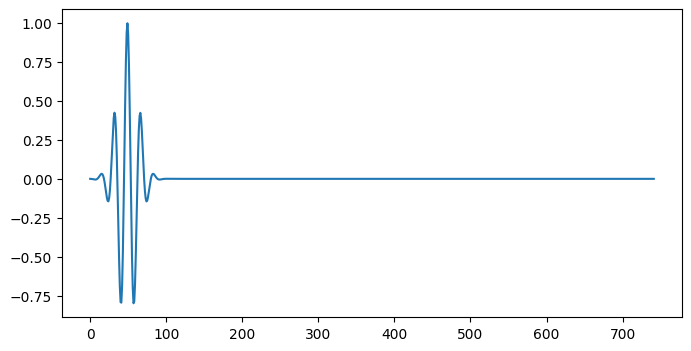

In [4]:
### Set up the time axis and source impulse
# CFL Condition
CFL = 0.3
c_max = jnp.max(C)
dtmax = CFL * dx / c_max

# Transmit pulse parameters
fctr = 0.2e6  # 200 kHz
fracBW = 0.5  # 50% fractional bandwidth

# Cutoff time (approximate duration of the pulse)
tc =  gauspuls_cutoff(fctr, fracBW)

# Time Axis
distmax = jnp.maximum(Nx * dx, Ny * dy)
c_min = jnp.min(C)
tend = tc + distmax / c_min
Nt = int(jnp.ceil(tend / dtmax)) + 1
dt = tend / (Nt - 1)

time = jnp.arange(0, Nt) * dt - tc
src_pulse = gauspuls(time, fctr, fracBW)
#src_pulse = src_pulse.reshape(1,-1)
print(src_pulse.shape)

### Visualize the Pulse
plt.figure(figsize=(8,4))
plt.plot(src_pulse)
plt.show()

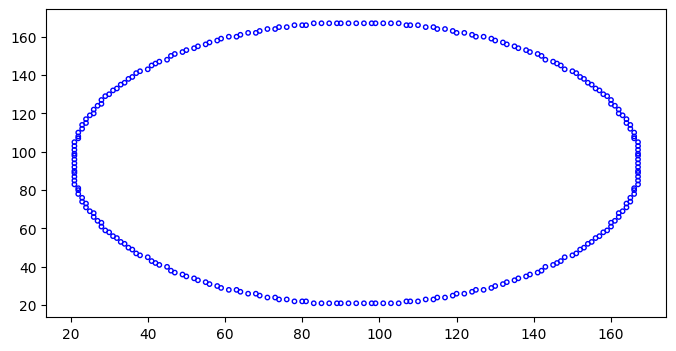

In [5]:
### Get the Sensor locations
# Transducer Ring
circle_radius = 110e-3  # in meters
Nelem = 256
theta = jnp.linspace(-jnp.pi, jnp.pi - 2 * jnp.pi / Nelem, Nelem)
x_circ = circle_radius * jnp.cos(theta)
y_circ = circle_radius * jnp.sin(theta)
circle_rad_pixels = circle_radius/dx

x_idx, y_idx, _ = sampled_circle(Nx, Ny, circle_rad_pixels, theta)

### Visualize the x_idx and y_idx for sanity
if 1==1:
    plt.figure(figsize=(8,4))
    plt.scatter(x_idx,y_idx, facecolors='none', edgecolors='b', s=10)

In [6]:
### Generate the Source
dwnsmp = 4
tx_include = list(range(0, Nelem, dwnsmp))
N_tx = len(tx_include)

SRC = jnp.zeros((Ny, Nx, Nt, N_tx))
mask = jnp.zeros((Ny, Nx, N_tx), dtype=jnp.float32)
mask = mask.at[
    y_idx[tx_include],      
    x_idx[tx_include],     
    jnp.arange(N_tx)       
].set(1.0)

mask = mask[..., None, :]   # now (Ny, Nx, 1, N_tx)
pulse = src_pulse[None, None, :, None]
SRC = mask * pulse
print(SRC.shape)

## Count Check with matlab
#len(np.where(SRC.flatten()!=0)[0])

### Visualize the Different SRC location for a fixed time points
if 0==1:
    tmpt=1
    U = SRC[:,:,tmpt,:]
    plt.figure(figsize=(4,4))
    for i in range(SRC.shape[3]):
        plt.imshow(U[:,:,i])
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.01)
    plt.show()

(189, 189, 742, 64)


In [18]:
### Solve Helmholtz Equation at Each Frequency
a0 = 0.02
L_PML = 30.0e-3
adjoint = False

## Naive Approch
#WVFIELD_T = getTimeStepping(x, y, C, SRC, time, a0, L_PML, adjoint)

## Vectorized Jax Scan Approach
#WVFIELD_T = getTimeStepping_vec(x, y, C, SRC, time, a0, L_PML, adjoint)

## Vectorized For_I loop Approch
WVFIELD_T = getTimeStepping_fori(x, y, C, SRC, time, a0, L_PML, adjoint)
print(WVFIELD_T.shape)

(189, 189, 742, 64)


In [88]:
### Generate the Channel Data
tmp = WVFIELD_T[y_idx,x_idx,:,:]
channelData = jnp.transpose(tmp, (1,0,2))
print(channelData.shape)

(742, 256, 64)


### Visualize the Wavefield & Channel Data

In [ ]:
### Visualize the Wavefield
isrc = 38
U = np.array(WVFIELD_T[..., isrc])   
time_np = np.array(time)             

fig, ax = plt.subplots(figsize=(4, 4))
vmin, vmax = -abs(U.flatten()).max(), abs(U.flatten()).max() #use this for reference to select vmin and vmax
im = ax.imshow(
    U[:, :, 0],
    vmin= -1e-7, #vmin, 
    vmax= 1e-7, #vmax,
    cmap='seismic',
    aspect='equal',
    extent=(x.min(), x.max(), y.min(), y.max())
)

ax.set_xlabel('x')
ax.set_ylabel('y')
title = ax.set_title(f'Wavefield Over Time, t = {time_np[0]*1e3:.2f} ms', fontsize=9)

display_handle = display(fig, display_id='wavefield')
for n in range(1,U.shape[2]):
    im.set_data(U[:, :, n])
    title.set_text(f'Wavefield Over Time, t = {time_np[n]*1e3:.2f} ms')
    display_handle.update(fig)
plt.close()


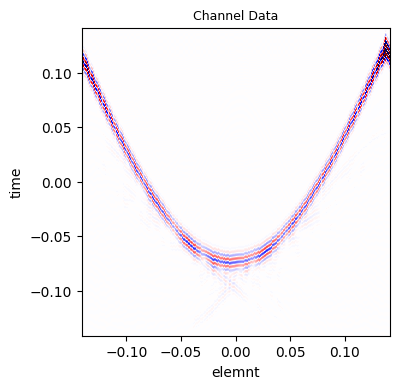

In [91]:
### Visualize the Channel Data
U = np.array(channelData)   

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(
    U[:, :, 0],
    vmin= -1e-7, 
    vmax= 1e-7,
    cmap='seismic',
    aspect='equal',
    extent=(x.min(), x.max(), y.min(), y.max())
)

ax.set_xlabel('elemnt')
ax.set_ylabel('time')
title = ax.set_title('Channel Data', fontsize=9)

display_handle = display(fig, display_id='wavefield')
for n in range(1,U.shape[2]):
    im.set_data(U[:, :, n])
    title.set_text('Channel Data')
    display_handle.update(fig)
    tt.sleep(0.1)
plt.close()


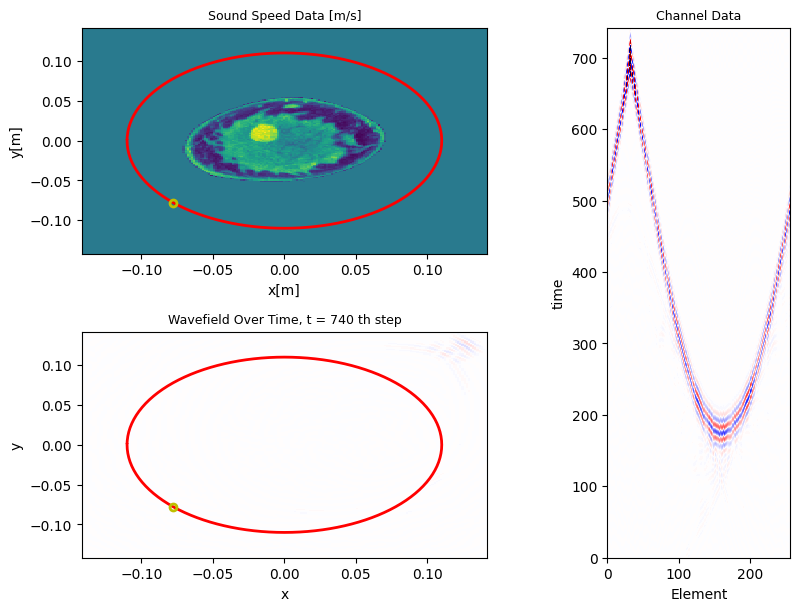

Text(0.5, 1.0, 'Channel Data')

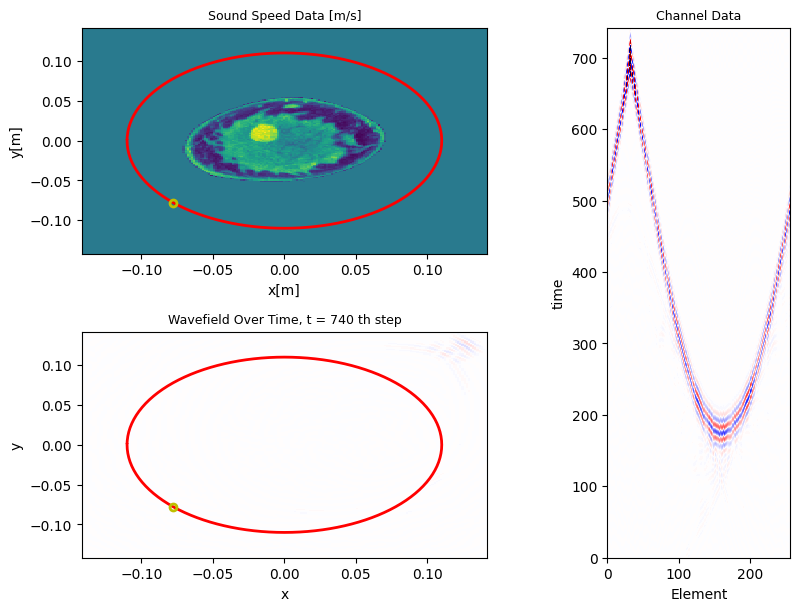

In [185]:
### Generate Wavefield as a Function fo Time
from matplotlib.gridspec import GridSpec

## plot 1
txidx = 8
UWV = np.array(WVFIELD_T[..., txidx]) 
channelData_nparr = np.array(channelData)
channelDataToShow = channelData_nparr[:,:,txidx]
time_idx_np = np.arange(0,Nt)

fig = plt.figure(figsize=(9,6), layout="constrained")
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:1])
ax2 = fig.add_subplot(gs[1, 0:1])
ax3 = fig.add_subplot(gs[:, 1:])

ax1.pcolormesh(x,y,C, cmap='viridis')
ax1.plot(x_circ, y_circ,'r', linewidth=2)
ax1.plot(x_circ[tx_include[txidx]], y_circ[tx_include[txidx]], 'yo', markerfacecolor='none', ms=5, markeredgewidth=2)
ax1.set_title('Sound Speed Data [m/s]', fontsize=9)
ax1.set_xlabel('x[m]')
ax1.set_ylabel('y[m]')

## plot 2
im1 = ax2.pcolormesh(x,y,
    UWV[:, :, 0],
    vmin= -1e-7, #vmin, 
    vmax= 1e-7, #vmax,
    cmap='seismic',
)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.plot(x_circ, y_circ,'r', linewidth=2)
ax2.plot(x_circ[tx_include[txidx]], y_circ[tx_include[txidx]], 'yo', markerfacecolor='none', ms=5, markeredgewidth=2)
title = ax2.set_title(f'Wavefield Over Time, t = {time_idx_np[0]} th step', fontsize=9)

## plot 3
im2 = ax3.imshow(
    channelDataToShow[0:5, 0:-1],
    vmin= -1e-7, 
    vmax= 1e-7, 
    cmap='seismic',
    extent=(0,len(theta),0,Nt)
)
ax3.set_xlabel('Element')
ax3.set_ylabel('time')
ax3.set_title('Channel Data', fontsize=9)
ax3.set_xlim([0, 256])
ax3.set_ylim([0, Nt])

display_handle = display(fig, display_id='wavefield')
for n in range(5,UWV.shape[2],5):
    im1.set_array(UWV[:, :, n])
    title.set_text(f'Wavefield Over Time, t = {time_idx_np[n]} th step')

    im2.set_data(channelDataToShow[5:n, 0:-1])
    display_handle.update(fig)



ax3.set_title('Channel Data', fontsize=9)



### Make GIF of Visualization

In [58]:
### Generate GIF for the Wavefield
isrc = 38
U = np.array(WVFIELD_T[..., isrc])   
time_np = np.array(time)             

fig, ax = plt.subplots(figsize=(4, 4))

for n in range(0,U.shape[2]):
    ax.imshow(U[:, :, n],vmin= -1e-7,vmax= 1e-7,cmap='seismic',
                aspect='equal',extent=(x.min(), x.max(), y.min(), y.max())
            )
    ax.set_title(f'Wavefield Over Time, t = {time_np[n]*1e3:.2f} ms', fontsize=9)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.savefig(f'results/4fwd_model/{n:003}') #dpi=200
    plt.close()

make_gif('results/4fwd_model/*.png',
        'results/TimeFrowardSample.gif')


In [92]:
### Generate GIF for the Wavefield
U =  np.array(channelData)           

fig, ax = plt.subplots(figsize=(4, 4))
for n in range(0,U.shape[2]):
    ax.imshow(U[:, :, n],vmin= -1e-7,vmax= 1e-7,cmap='seismic',
                aspect='equal',extent=(x.min(), x.max(), y.min(), y.max())
            )
    ax.set_title(f'Channel Data', fontsize=9)
    ax.set_xlabel('Element')
    ax.set_ylabel('time [micro-sec]')
    fig.savefig(f'results/4wd_channeldata/{n:003}') #dpi=200
    plt.close()

make_gif('results/4wd_channeldata/*.png',
        'results/ChannelDataSample.gif')


In [191]:
### Generate GIF for Wavefield as a Function fo Time
from matplotlib.gridspec import GridSpec

## plot 1
txidx = 8
UWV = np.array(WVFIELD_T[..., txidx]) 
channelData_nparr = np.array(channelData)
channelDataToShow = channelData_nparr[:,:,txidx]
time_idx_np = np.arange(0,Nt)

fig = plt.figure(figsize=(9,6), layout="constrained")
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:1])
ax2 = fig.add_subplot(gs[1, 0:1])
ax3 = fig.add_subplot(gs[:, 1:])

ax1.pcolormesh(x,y,C, cmap='viridis')
ax1.plot(x_circ, y_circ,'r', linewidth=2)
ax1.plot(x_circ[tx_include[txidx]], y_circ[tx_include[txidx]], 'yo', markerfacecolor='none', ms=5, markeredgewidth=2)
ax1.set_title('Sound Speed Data [m/s]', fontsize=9)
ax1.set_xlabel('x[m]')
ax1.set_ylabel('y[m]')

for n in range(0,UWV.shape[2],5):
    ax2.pcolormesh(x,y,
    UWV[:, :, n],
    vmin= -1e-7, #vmin, 
    vmax= 1e-7, #vmax,
    cmap='seismic',
    )
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.plot(x_circ, y_circ,'r', linewidth=2)
    ax2.plot(x_circ[tx_include[txidx]], y_circ[tx_include[txidx]], 'yo', markerfacecolor='none', ms=5, markeredgewidth=2)
    ax2.set_title(f'Wavefield Over Time, t = {time_idx_np[n]} th step', fontsize=9)

    ax3.imshow(
    channelDataToShow[0:n, 0:-1],
    vmin= -1e-7, 
    vmax= 1e-7, 
    cmap='seismic',
    extent=(0,len(theta),0,Nt)
    )
    ax3.set_xlabel('Element')
    ax3.set_ylabel('time')
    ax3.set_title('Channel Data', fontsize=9)
    ax3.set_xlim([0, 256])
    ax3.set_ylim([0, Nt])
    ax3.set_title('Channel Data', fontsize=9)
    
    fig.savefig(f'results/4wd_allplots/{n:003}') #dpi=200
    plt.close()


make_gif('results/4wd_allplots/*.png',
        'results/WaveFiledAllPlots.gif', dur=250)


### Addiitonal Draft Codes

In [144]:
# import h5py
# with h5py.File('/home/urseismoadmin/Documents/INV_PRB_IMG/data/tempWaveField.mat', 'r') as f:
#     # MATLAB stores datasets under their variable names
#     U = f['U'][:]   
# print(U.shape)
# U = np.transpose(U,(1,2,0))
# print(U.shape)

# plt.figure(figsize=(4,4))
# # plt.pcolormesh(x,y,U[:,:,300], cmap='viridis')
# plt.imshow(U[:,:,300])
# plt.show()

# with h5py.File('/home/urseismoadmin/Documents/INV_PRB_IMG/data/SrcPulseMat.mat', 'r') as f:
#     SRCtmp = f['temp'][:]
# print(SRCtmp.shape)
# SRCtmp = np.transpose(SRCtmp,(1,2,0))
# print(SRCtmp.shape)

#plt.plot(SRCtmp.flatten()[np.where(SRCtmp.flatten()!=0)[0]])

# temp = np.random.randint(1, 10, size=(189, 189,1,64))
# temp.shape
# temp2 = np.random.randint(1, 10, size=(189, 189))
# temp2.shape
# val = temp*temp2[...,None,None]
# val.shape


#### Dynamically Updating Figures 1
# from IPython.display import display, clear_output
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1) 
# for i in range(21):
#     ax.set_xlim(0, 20)
#     ax.plot(i, 1,marker='x')
#     display(fig)
#     clear_output(wait = True)
#     plt.pause(0.5)

#### Dynamically Updating Figures 2
#from IPython import display
# tmpt = 1
# U = SRC[:,:,tmpt,:]

# plt.figure(figsize=(4,4))
# for i in range(SRC.shape[3]):
#     plt.imshow(U[:,:,i])
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     plt.pause(0.01)
# plt.show()

#### Dynamically Updating Figures 3
# from IPython import display
# isrc = 38
# U = WVFIELD_T[:,:,:,isrc]

# if 1==1:
#     plt.figure(figsize=(4,4))
#     for i in range(Nt):
#         plt.imshow(U[:,:,i])
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         plt.pause(0.001)
#     plt.show()

#### Dynamically Updating Figures 4
# import time
# from IPython.display import display

# # convert to NumPy once
# U = np.array(WVFIELD_T[..., isrc])   # shape (Ny, Nx, Nt)
# time_np = np.array(time)             # shape (Nt,)

# # precompute color‐scale
# vmin, vmax = -abs(U.flatten()).max(), abs(U.flatten()).max()

# # create figure + axes + image once
# fig, ax = plt.subplots(figsize=(4, 4))
# im = ax.imshow(
#     U[:, :, 0],
#     origin='lower',
#     vmin=vmin, vmax=vmax,
#     cmap='hot',
#     #aspect='equal',
#     #extent=(x.min(), x.max(), y.min(), y.max())
# )
# #cbar = fig.colorbar(im, ax=ax)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# #title = ax.set_title(f't = {time_np[0]*1e3:.2f} ms')

# # display it once, capturing the handle
# display_handle = display(fig, display_id='wavefield')

# # update loop
# for n in range(U.shape[2]):
#     im.set_data(U[:, :, n])
#     #title.set_text(f't = {time_np[n]*1e3:.2f} ms')
#     display_handle.update(fig)
#     time.sleep(0.001)

#     if n==100:
#         break

    
#### Calculaitng Source Old Code
# SRC = jnp.zeros((Ny, Nx, Nt, N_tx))
# for tx in range(N_tx):
#     #pulse = jnp.broadcast_to(src_pulse, (Nt,))
#     SRC = SRC.at[y_idx[tx_include[tx]], x_idx[tx_include[tx]], :, tx].set(src_pulse)


